In [ ]:
import re
import string
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D,Input
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Activation, Dropout
from tensorflow.keras.layers import Conv1D, Embedding
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing import image

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
df_labels = pd.read_csv('/content/drive/My Drive/Shakuntal/labels.csv')
df_labels.drop(df_labels.columns[df_labels.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
df_labels = df_labels.drop(columns = ['text_ocr'])
df_labels.dropna(inplace=True)
df_labels.head()

,image_name,text_corrected,humour,sarcasm,offensive,motivational,overall_sentiment
0,image_1.jpg,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,hilarious,general,not_offensive,not_motivational,positive
1,image_2.jpeg,The best of #10 YearChallenge! Completed in le...,not_funny,general,not_offensive,motivational,positive
2,image_3.JPG,Sam Thorne @Strippin ( Follow Follow Saw every...,very_funny,not_sarcastic,not_offensive,not_motivational,positive
3,image_4.png,10 Year Challenge - Sweet Dee Edition,very_funny,twisted_meaning,very_offensive,motivational,positive
4,image_5.png,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,hilarious,very_twisted,very_offensive,not_motivational,neutral


In [ ]:
import pandas as pd


df = pd.DataFrame(df_labels)

sentiment_mapping = {
    'humour': {
        'funny': 'positive',
        'very_funny': 'positive',
        'hilarious': 'positive',
        'not_funny': 'negative'
    },
    'sarcasm': {
        'general': 'negative',
        'not_sarcastic': 'negative',
        'twisted_meaning': 'positive',
        'very_twisted': 'positive'
    },
    'offensive': {
        'not_offensive': 'negative',
        'slight': 'positive',
        'very_offensive': 'positive',
        'hateful_offensive': 'positive'
    },
    'motivational': {
        'motivational': 'positive',
        'not_motivational': 'negative'
    },
    'overall_sentiment': {
        'positive': 'positive',
        'neutral': 'neutral',
        'negative': 'negative'
    }
}
for category, mapping in sentiment_mapping.items():
    df[category + '_sentiment'] = df[category].map(mapping)

for category in sentiment_mapping:
    print(f"\nSentiment counts for '{category}':")
    print(df[category + '_sentiment'].value_counts())



Sentiment counts for 'humour':
humour_sentiment
positive    5338
negative    1649
Name: count, dtype: int64

Sentiment counts for 'sarcasm':
sarcasm_sentiment
negative    5047
positive    1940
Name: count, dtype: int64

Sentiment counts for 'offensive':
offensive_sentiment
positive    4277
negative    2710
Name: count, dtype: int64

Sentiment counts for 'motivational':
motivational_sentiment
negative    4522
positive    2465
Name: count, dtype: int64

Sentiment counts for 'overall_sentiment':
overall_sentiment_sentiment
positive    4156
neutral     2200
negative     631
Name: count, dtype: int64


In [ ]:
cleaned = df_labels.copy()
cleaned.dropna(inplace=True)
cleaned.isnull().any()

,0
image_name,False
text_corrected,False
humour,False
sarcasm,False
offensive,False
motivational,False
overall_sentiment,False


In [ ]:
import os

image_directory = '/content/drive/My Drive/Shakuntal/images/'
image_files = os.listdir(image_directory)
print(f"Number of images found: {len(image_files)}")

import pandas as pd

text_data_path = '/content/drive/My Drive/Shakuntal/labels.csv'
cleaned = pd.read_csv(text_data_path)

print(f"Number of entries in metadata: {len(cleaned)}")

existing_image_names = set(image_files)
cleaned = cleaned[cleaned['image_name'].isin(existing_image_names)]
print(f"Number of valid entries after filtering: {len(cleaned)}")


Number of images found: 7002
Number of entries in metadata: 6992
Number of valid entries after filtering: 6992


In [ ]:
width = 100
height = 100
X = []
for i in tqdm(range(cleaned.shape[0])):
    if i in []:
        pass
    else:
        path = '/content/drive/My Drive/Shakuntal/images/'+cleaned['image_name'][i]
        img = image.load_img(path,target_size=(width,height,3))
        img = image.img_to_array(img)
        img = img/255.0
        X.append(img)

X = np.array(X)

 95%|█████████▌| 6674/6992 [02:56<00:02, 136.44it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 6992/6992 [02:58<00:00, 39.07it/s] 


In [ ]:
X.shape

(6992, 100, 100, 3)

In [ ]:
target = cleaned['overall_sentiment']
target = pd.get_dummies(target)
target.head()

,negative,neutral,positive
0,False,False,True
1,False,False,True
2,False,False,True
3,False,False,True
4,False,True,False


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size = 0.2, stratify=target)


In [ ]:
import tensorflow as tf
image_input = Input(shape=(100, 100, 3), name='image_input')

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomContrast(0.5),  # Changed from [0.5, 2] to a single float
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.1)
])
preprocess_input = tf.keras.applications.resnet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)
augmented_image = data_augmentation(image_input)


In [ ]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (5593, 100, 100, 3)
X_test shape: (1399, 100, 100, 3)
y_train shape: (5593, 3)
y_test shape: (1399, 3)


In [ ]:
base_model_1 = tf.keras.applications.ResNet50(input_shape=X[0].shape,
                                               include_top=False,
                                               weights='imagenet')
base_model_2 = tf.keras.applications.VGG16(input_shape=X[0].shape,
                                               include_top=False,
                                               weights='imagenet')

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
base_model_1.trainable = False
base_model_2.trainable = False

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.applications import ResNet50, VGG16

def image_model():
    image_input_resnet = Input(shape=(100, 100, 3), name='image_input_resnet')
    image_input_vgg = Input(shape=(100, 100, 3), name='image_input_vgg')
    augmented_image_resnet = data_augmentation(image_input_resnet)
    augmented_image_vgg = data_augmentation(image_input_vgg)
    image_input = Input(shape=(100, 100, 3), name='image_input')
    image_layers = data_augmentation(image_input)

    # Define base model 1 (ResNet50)
    base_model_1 = ResNet50(weights='imagenet', include_top=False, input_tensor=augmented_image_resnet)
    x1 = base_model_1(augmented_image_resnet, training=False)
    x1 = Conv2D(2048, kernel_size=2, padding='valid')(x1)
    x1 = GlobalAveragePooling2D()(x1)
    x1 = Dense(512)(x1)

    # Define base model 2 (VGG16)
    base_model_2 = VGG16(weights='imagenet', include_top=False, input_tensor=augmented_image_vgg)
    x2 = base_model_2(augmented_image_vgg, training=False)
    x2 = GlobalAveragePooling2D()(x2)
    x2 = Dense(512)(x2)

    # Concatenate the outputs of both base models
    layers = tf.keras.layers.concatenate([x1, x2])

    # Apply dropout
    image_layers = Dropout(0.2, name='dropout_layer')(layers)

    return [image_input_resnet, image_input_vgg], image_layers

# Create the model
image_input, image_layers = image_model()

# Create the model instance
model = tf.keras.Model(inputs=image_input, outputs=image_layers)

# Print the model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image_input_resnet        │ (None, 100, 100, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 100, 100, 3)    │              0 │ image_input_resnet[0]… │
│                           │                        │                │ image_input_vgg[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ image_input_vgg           │ (None, 100, 100, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50 (Functional)     │ (None, 4, 4, 2048)     │     23,587,712 │ sequential[1][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 3, 3, 2048)     │     16,779,264 │ resnet50[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg16 (Functional)        │ (None, 3, 3, 512)      │     14,714,688 │ sequential[2][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 2048)           │              0 │ conv2d[0][0]           │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 512)            │              0 │ vgg16[0][0]            │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 512)            │      1,049,088 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 512)            │        262,656 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 1024)           │              0 │ dense[0][0],           │
│                           │                        │                │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_layer (Dropout)   │ (None, 1024)           │              0 │ concatenate[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 56,393,408 (215.12 MB)

 Trainable params: 56,340,288 (214.92 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
import pandas as pd
import re
import string

def standardization(data):
    data = data.astype(str)  # Convert all data to string
    data = data.apply(lambda x: x.lower())
    data = data.apply(lambda x: re.sub(r'\d+', '', x))
    data = data.apply(lambda x: re.sub(r'.com', '', x, flags=re.MULTILINE))
    data = data.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
    return data

cleaned['text_corrected'] = standardization(cleaned['text_corrected'])



In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

# vocabulary size and sequence length
vocab_size = 10000
sequence_length = 50

# TextVectorization layer
vectorize_layer = TextVectorization(
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length
)


text_ds = np.asarray(cleaned['text_corrected'])

#vectorization layer to the text data
vectorize_layer.adapt(tf.convert_to_tensor(text_ds))


print(vectorize_layer.get_vocabulary())

['', '[UNK]', 'the', 'you', 'a', 'i', 'to', 'and', 'is', 'of', 'when', 'in', 'my', 'me', 'your', 'it', 'for', 'that', 'this', 'on', 'like', 'be', 'are', 'with', 'memes', 'have', 'not', 'imgflip', 'im', 'bill', 'dont', 'what', 'but', 'if', 'just', 'at', 'was', 'he', 'so', 'we', 'no', 'do', 'meme', 'one', 'they', 'all', 'its', 'how', 'quickmeme', 'his', 'can', 'who', 'about', 'memecenter', 'youre', 'know', 'will', 'get', 'an', 'out', 'up', 'make', 'people', 'as', 'by', 'because', 'from', 'memegeneratornet', 'why', 'time', 'now', 'has', 'see', 'her', 'only', 'never', 'friends', 'more', 'him', 'got', 'think', 'cant', 'love', 'want', 'look', 'go', 'she', 'doesnt', 'someone', 'say', 'best', 'did', 'made', 'then', 'day', 'would', 'there', 'am', 'them', 'man', 'girlfriend', 'friend', 'their', 'trump', 'or', 'always', 'said', 'new', 'were', 'u', 'good', 'girl', 'country', 'life', 'thats', 'need', 'says', 'hillary', 'here', 'first', 'still', 'back', 'women', 'hitler', 'after', 'too', 'than', 'li

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# multi-dimensional target to 1D
if target.ndim > 1:
    y_stratify = np.argmax(target, axis=1)
else:
    y_stratify = target


print(f"Length of cleaned.text_corrected: {len(cleaned.text_corrected)}")
print(f"Length of y_stratify: {len(y_stratify)}")

# train-test split
X_text_train, X_text_test, y_text_train, y_text_test = train_test_split(
    cleaned.text_corrected, y_stratify, test_size=0.2, stratify=y_stratify, random_state=42
)

print(f"Shape of X_text_train: {len(X_text_train)}")
print(f"Shape of X_text_test: {len(X_text_test)}")
print(f"Shape of y_text_train: {len(y_text_train)}")
print(f"Shape of y_text_test: {len(y_text_test)}")


Length of cleaned.text_corrected: 6992
Length of y_stratify: 6992
Shape of X_text_train: 5593
Shape of X_text_test: 1399
Shape of y_text_train: 5593
Shape of y_text_test: 1399


In [ ]:
embedding_dim=16

def text_model():
    text_input = tf.keras.Input(shape=(None,), dtype=tf.string, name='text')
    text_layers = vectorize_layer(text_input)
    text_layers = tf.keras.layers.Embedding(vocab_size, embedding_dim, name="embedding")(text_layers)

    text_layers = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, activation='relu', return_sequences=True,dropout=0.2, recurrent_dropout=0.2))(text_layers)
    text_layers = tf.keras.layers.BatchNormalization()(text_layers)

    text_layers = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(512, activation='relu', return_sequences=True,dropout=0.2, recurrent_dropout=0.2))(text_layers)
    text_layers = tf.keras.layers.BatchNormalization()(text_layers)

    text_layers = tf.keras.layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(text_layers)

    text_layers = tf.keras.layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(text_layers)
    text_layers = tf.keras.layers.GlobalMaxPooling1D()(text_layers)

    text_layers = tf.keras.layers.Dense(1024, activation="relu")(text_layers)
    text_layers = tf.keras.layers.Dropout(0.5)(text_layers)
    return text_input, text_layers

text_input, text_layers = text_model()

# Create a Keras Model
model = tf.keras.Model(inputs=text_input, outputs=text_layers)

# Print the model summary
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text (InputLayer)                    │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization                   │ (None, 50)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 50, 16)              │         160,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 50, 1024)            │       2,166,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 50, 1024)            │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 50, 1024)            │       4,724,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 50, 1024)            │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 15, 128)             │         917,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 3, 128)              │         114,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 128)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1024)                │         132,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,224,256 (31.37 MB)

 Trainable params: 8,220,160 (31.36 MB)

 Non-trainable params: 4,096 (16.00 KB)

In [ ]:
def model(layer_1, layer_2, image_input, text_input):
    concatenate = tf.keras.layers.concatenate([layer_1, layer_2], axis=1)
    semi_final_layer = tf.keras.layers.Dense(2048, activation='relu')(concatenate)

    prediction_layer = tf.keras.layers.Dense(3, activation='softmax', name = 'task_a')

    output = prediction_layer(semi_final_layer)

    model = tf.keras.Model(inputs = [image_input, text_input] ,
                           outputs = output)
    return model

In [ ]:
model = model(image_layers, text_layers, image_input, text_input)

In [ ]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ text (InputLayer)         │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text_vectorization        │ (None, 50)             │              0 │ text[0][0]             │
│ (TextVectorization)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 50, 16)         │        160,000 │ text_vectorization[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 50, 1024)       │      2,166,784 │ embedding[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ image_input_resnet        │ (None, 100, 100, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 50, 1024)       │          4,096 │ bidirectional[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 100, 100, 3)    │              0 │ image_input_resnet[0]… │
│                           │                        │                │ image_input_vgg[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ image_input_vgg           │ (None, 100, 100, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 50, 1024)       │      4,724,736 │ batch_normalization[0… │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50 (Functional)     │ (None, 4, 4, 2048)     │     23,587,712 │ sequential[1][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 50, 1024)       │          4,096 │ bidirectional_1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 3, 3, 2048)     │     16,779,264 │ resnet50[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg16 (Functional)        │ (None, 3, 3, 512)      │     14,714,688 │ sequential[2][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 15, 128)        │        917,632 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 2048)           │              0 │ conv2d[0][0]           │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├──────────────────────

 Total params: 68,820,163 (262.53 MB)

 Trainable params: 68,762,947 (262.31 MB)

 Non-trainable params: 57,216 (223.50 KB)

In [ ]:
import os
# Define the checkpoint directory to store the checkpoints
checkpoint_dir = './training_checkpoints'

# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

In [ ]:
def decay(epoch):
    if epoch < 5:
        return 1e-3
    elif epoch >= 5 and epoch < 10:
        return 1e-4
    else:
        return 1e-5

In [ ]:
checkpoint_prefix = './training_checkpoints/ckpt_{epoch}.weights.h5'


In [ ]:
class PrintLearningRate(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    print('\nLearning rate for epoch {} is {}'.format(epoch + 1,
                                                      model.optimizer.learning_rate.numpy()))

callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,
                                       save_weights_only=True),
    tf.keras.callbacks.LearningRateScheduler(decay),
    PrintLearningRate()
]

In [ ]:
#optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-4)

#model.compile(optimizer=optimizer,
              #loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              #metrics=['categorical_accuracy'])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])




In [ ]:
history = model.fit(
        x={
            "image_input_resnet": X_train,
            "image_input_vgg": X_train,
            "text": X_text_train
        },
        y=y_train,
        batch_size=128,
        epochs=20
)



Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - categorical_accuracy: 0.4811 - loss: 11.9297
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - categorical_accuracy: 0.5864 - loss: 0.9056
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - categorical_accuracy: 0.5875 - loss: 0.9020
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - categorical_accuracy: 0.5970 - loss: 0.8781
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - categorical_accuracy: 0.6050 - loss: 0.8080
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - categorical_accuracy: 0.6881 - loss: 0.6670
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - categorical_accuracy: 0.7388 - loss: 0.5831
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - categorical_accuracy: 0.7921 - loss: 0.4829
Epoch 9/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - categorical_accuracy: 0.8120 - loss: 0.4403
Epoch 10/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - categorical_accuracy: 0.8395 - loss: 0.3635
Epoch 11/20
44/44 ━━━━━━━━━━━━━━━━━━━

In [ ]:
df_history = pd.DataFrame(history.history)
df_history

,categorical_accuracy,loss
0,0.544073,5.074650
1,0.593599,0.904087
2,0.595029,0.896598
3,0.589308,0.882114
4,0.619524,0.786369
5,0.688360,0.674137
6,0.743072,0.582977
7,0.783122,0.494439
8,0.811014,0.443809
9,0.829966,0.397897


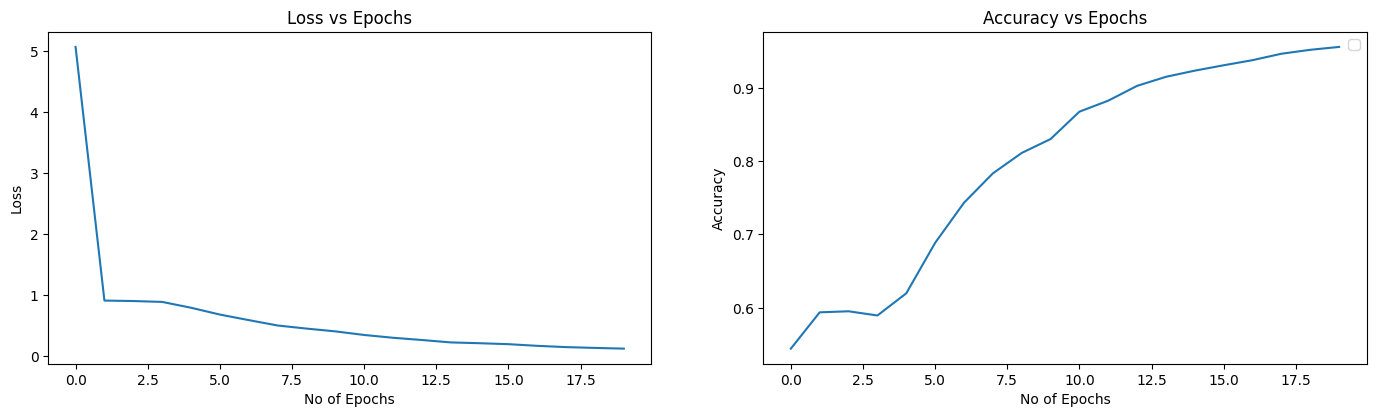

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(15, 5))
fig.tight_layout(pad=5.0)

axes[0].plot(df_history.loss)
axes[0].set_xlabel('No of Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss vs Epochs')

#axes[1].plot(df_history.binary_accuracy)
axes[1].plot(df_history.categorical_accuracy)
axes[1].set_xlabel('No of Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy vs Epochs')
axes[1].legend()
plt.show()

In [ ]:
model_eval = model.evaluate(
        x={
            "image_input_resnet": X_test,
            "image_input_vgg": X_test,
            "text": X_text_test
        },
        y=y_test,
        batch_size=64,
        verbose=1
)


22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 298ms/step - categorical_accuracy: 0.4506 - loss: 1.9509


In [ ]:
prediction = model.predict(x={
            "image_input_resnet": X_test,
            "image_input_vgg": X_test,
            "text": X_text_test
        },)
prediction = np.array(prediction)
prediction = np.squeeze(prediction)
prediction = 1/(1+np.exp(-np.array(prediction)))
prediction = np.where(prediction > 0.5, 1, 0)
y_true = y_test.values

micro_f1_score = f1_score(y_true[:,1], prediction[:,1], average='micro')
macro_f1_score = f1_score(y_true[:,1], prediction[:,1], average='macro')

print("Micro F1 score for Task A is ", micro_f1_score)
print("Macro F1 score for Task A is ", macro_f1_score)

44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 213ms/step
Micro F1 score for Task A is  0.3166547533952823
Macro F1 score for Task A is  0.24201804497642362


44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step


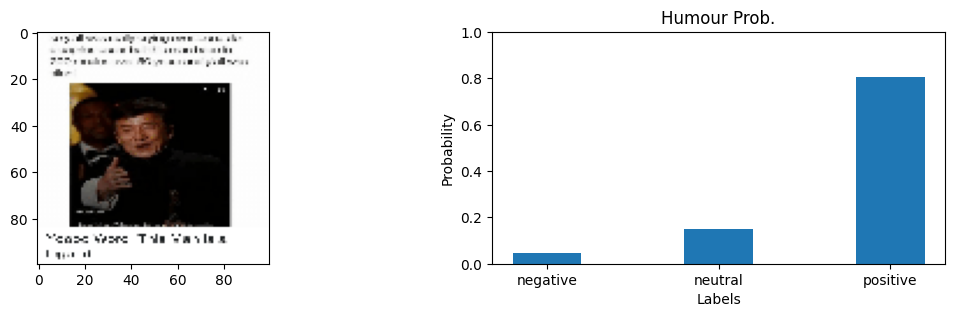

In [ ]:
import random
import matplotlib.pyplot as plt


fig, axes = plt.subplots(1, 2, figsize=(12, 4))
fig.tight_layout(pad=5.0)

axes[0].imshow(X[random.randint(0, X_test.shape[0] - 1), :, :, :])

x = list(y_test.columns)

axes[1].bar(
    x,
    model.predict({
        "image_input_resnet": X_test,
        "image_input_vgg": X_test,
        "text": X_text_test
    })[random.randint(0, X_test.shape[0] - 1), :],
    width=0.4
)

axes[1].set_xlabel('Labels')
axes[1].set_ylabel('Probability')
axes[1].set_title('Humour Prob.')
axes[1].set_xticks(range(len(x)))  # Ensure the x-ticks align with the labels
axes[1].set_xticklabels(x)
axes[1].set_ylim(0, 1)


plt.show()


In [ ]:
from tensorflow.keras.models import save_model

model.save('/content/drive/My Drive/Shakuntal/model_task1.keras')


44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step


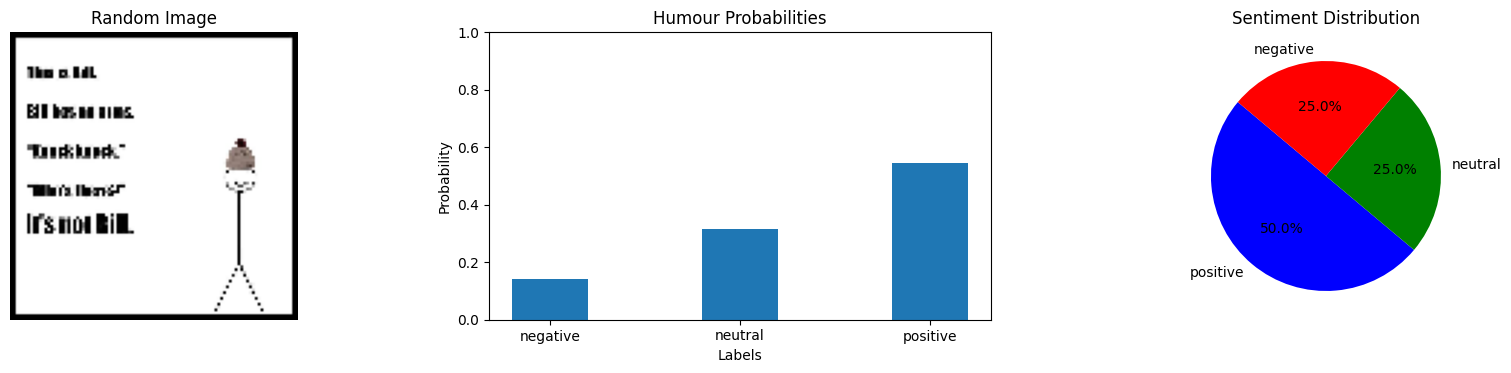

In [ ]:
import random
import matplotlib.pyplot as plt
import padas as pd

# Sample Data
data = {
    'overall_sentiment': ['positive', 'positive', 'positive', 'neutral', 'negative', 'neutral', 'positive', 'negative']
}
df = pd.DataFrame(data)

sentiment_counts = df['overall_sentiment'].value_counts()

fig, axes = plt.subplots(1, 3, figsize=(18, 4))  # Adjust the figure size to accommodate all subplots
fig.tight_layout(pad=3.0)

axes[0].imshow(X[random.randint(0, X_test.shape[0] - 1), :, :, :])
axes[0].set_title('Random Image')
axes[0].axis('off')  # Hide axis for the image

x = list(y_test.columns)

axes[1].bar(
    x,
    model.predict({
        "image_input_resnet": X_test,
        "image_input_vgg": X_test,
        "text": X_text_test
    })[random.randint(0, X_test.shape[0] - 1), :],
    width=0.4
)
axes[1].set_xlabel('Labels')
axes[1].set_ylabel('Probability')
axes[1].set_title('Humour Probabilities')
axes[1].set_xticks(range(len(x)))
axes[1].set_xticklabels(x)
axes[1].set_ylim(0, 1)

colors = ['blue', 'green', 'red']  # Colors for positive, neutral, and negative
axes[2].pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=colors)
axes[2].set_title('Sentiment Distribution')

plt.show()


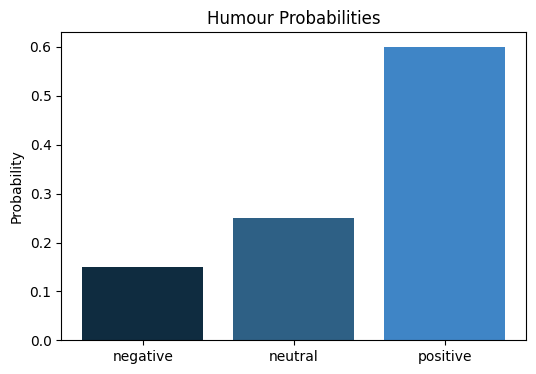

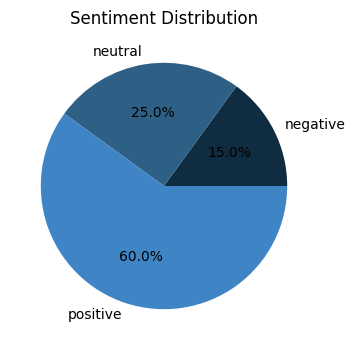

In [ ]:
import matplotlib.pyplot as plt

probabilities = [0.15, 0.25, 0.60]  # Replace with your actual probabilities
labels = ['negative', 'neutral', 'positive']

colors = ['#0F2C40', '#2E6085', '#3F85C6']  # Light pink, Hot pink, Deep pink

plt.figure(figsize=(6, 4))
plt.bar(labels, probabilities, color=colors)
plt.title('Humour Probabilities')
plt.ylabel('Probability')
plt.show()

plt.figure(figsize=(6, 4))
plt.pie(probabilities, labels=labels, colors=colors, autopct='%1.1f%%')
plt.title('Sentiment Distribution')
plt.show()

